
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Climate emulator output generation

inputs required: 
  * emulator output - synthetic wave and water level conditions
  * Projected Sea Level Rise at the Site (for the 3 SLR scenarios: intermediate low, intermediate, intermediate high))

  
in this notebook:
  * plot the synthetic values of the analyzed variables (TWL)
  * generation of hourly values of the synthetic time series of TWL


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..','..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates, repair_times_hourly, add_max_storms_mask, fast_reindex_hourly, fast_reindex_hourly_nsim

from teslakit.plotting.outputs import Plot_Complete



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

# offshore
db = Database(p_data)
db.SetSite('ROI')

# climate change - S1
db_S1 = Database(p_data)
db_S1.SetSite('ROI_CC_S1')

# climate change - S2
db_S2 = Database(p_data)
db_S2.SetSite('ROI_CC_S2')

# climate change - S1
db_S3 = Database(p_data)
db_S3.SetSite('ROI_CC_S3')




## Compute TWL taking into account SLR

In [3]:
# Load SLR file

SLR = db.Load_SeaLevelRise()
SLR['time'] = SLR.time.dt.round('H')
print(SLR)

<xarray.Dataset>
Dimensions:   (scenario: 3, time: 885360)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 ... 2100-12-31T23:00:00
  * scenario  (scenario) object '0.5' '1.0' '1.5'
Data variables:
    SLR       (time, scenario) float32 ...


In [4]:
n_sims_DWTs = 10

# iterate simulations
for n in range(n_sims_DWTs):
 
    SIM_n = db.Load_SIM_OFFSHORE(n_sim=n, vns=['AWL', 'SS', 'AT', 'MMSL' ], decode_times=True, use_cftime=True)

    # use available SLR dates     
    SIM_n = SIM_n.isel(time=slice(0, len(SLR.time)))
    
    #----------------------------
    # calculate TWL taking into account SLR scenario S1
    SIM_slr = SIM_n.copy(deep=True)
    SIM_slr['TWL'] = SIM_slr['AWL'] + SIM_slr['SS'] + SIM_slr['AT'] + SIM_slr['MMSL'] + SLR['SLR'].sel(scenario='0.5').values
    
    # store hourly simulation offshore TWL data
    SIM_slr = SIM_slr.drop({'AWL','SS', 'AT','MMSL'})
    db_S1.Save_SIM_OFFSHORE(SIM_slr, n)
    

    #----------------------------
    # calculate TWL taking into account SLR scenario S2
    SIM_slr = SIM_n.copy(deep=True)
    SIM_slr['TWL'] = SIM_slr['AWL'] + SIM_slr['SS'] + SIM_slr['AT'] + SIM_slr['MMSL'] + SLR['SLR'].sel(scenario='1.0').values
    
    # store hourly simulation offshore TWL data
    SIM_slr = SIM_slr.drop({'AWL','SS', 'AT','MMSL'})
    db_S2.Save_SIM_OFFSHORE(SIM_slr, n)
    

    #----------------------------
    # calculate TWL taking into account SLR scenario S3
    SIM_slr = SIM_n.copy(deep=True)
    SIM_slr['TWL'] = SIM_slr['AWL'] + SIM_slr['SS'] + SIM_slr['AT'] + SIM_slr['MMSL'] + SLR['SLR'].sel(scenario='1.5').values
    
    # store hourly simulation offshore TWL data
    SIM_slr = SIM_slr.drop({'AWL','SS', 'AT','MMSL'})
    db_S3.Save_SIM_OFFSHORE(SIM_slr, n)
   
    
    print('simulation {0} processed.'.format(n))
    


simulation 0 processed.
simulation 1 processed.
simulation 2 processed.
simulation 3 processed.
simulation 4 processed.
simulation 5 processed.
simulation 6 processed.
simulation 7 processed.
simulation 8 processed.
simulation 9 processed.


([<matplotlib.lines.Line2D at 0x13a160eb8>],
 [],
 (0, 885360),
 <matplotlib.legend.Legend at 0x11adec7b8>)

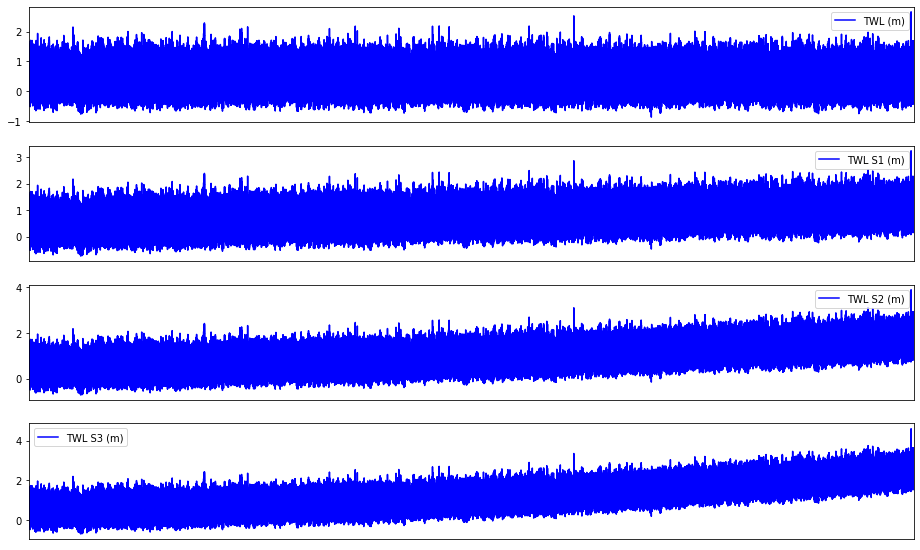

In [16]:
# Plot one Simulation of TWL for different SLR scenarios (100 years)

from teslakit.plotting.config import _faspect, _fsize
import matplotlib.gridspec as gridspec


n_sim = 0
SIM_p = db.Load_SIM_OFFSHORE(n_sim,vns=['TWL']) # 1000 years
SIM_p_S1 = db_S1.Load_SIM_OFFSHORE(n_sim,vns=['TWL'])
SIM_p_S2 = db_S2.Load_SIM_OFFSHORE(n_sim,vns=['TWL'])
SIM_p_S3 = db_S3.Load_SIM_OFFSHORE(n_sim,vns=['TWL'])

SIM_p = SIM_p.isel(time=slice(0, len(SIM_p_S1.time))) # 100 years


# plot figure
fig, axs = plt.subplots(4, 1, figsize=(_faspect*_fsize, _fsize));

# Sim
axs[0].plot(SIM_p.TWL.values, label='TWL (m)', color='blue'), axs[0].set_xticks([]), axs[0].set_xlim(0,len(SIM_p_S1.time)), axs[0].legend()

# Sim SLR S1
axs[1].plot(SIM_p_S1.TWL.values, label='TWL S1 (m)', color='blue'), axs[1].set_xticks([]), axs[1].set_xlim(0,len(SIM_p_S1.time)), axs[1].legend()

# Sim SLR S2
axs[2].plot(SIM_p_S2.TWL.values, label='TWL S2 (m)', color='blue'), axs[2].set_xticks([]), axs[2].set_xlim(0,len(SIM_p_S1.time)), axs[2].legend()

# Sim SLR S3
axs[3].plot(SIM_p_S3.TWL.values, label='TWL S3 (m)', color='blue'), axs[3].set_xticks([]), axs[3].set_xlim(0,len(SIM_p_S1.time)), axs[3].legend()
